In [ ]:
# !pip install gtts pydub audioop-lts
from gtts import gTTS
from pydub import AudioSegment
import time
import os
import pandas as pd
from datetime import date
import glob
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont
from moviepy import ImageClip, CompositeVideoClip, AudioFileClip
from pydub.exceptions import CouldntDecodeError
pd.options.display.max_columns = 100
pd.options.display.max_rows = 130

# 0. Choose setting

In [154]:
making_video = True
for_yt = False
recording_id_codes = {
    '001': 'full_word_sent',
    '004': 'word_only',
    '012': 'efirst_csent',
    '006': 'ecombo',
    '013': 'ccombo_sent',
    '014': 'cinna_sent',
    '015': 'conly_sent',
    '016': 'efirst_word_only',
}
WORD_TYPES = ['combo', 'no combo', 'two word', 'prefix', 'single char', 'suffix', 'abbreviation']
PHRASE_TYPES = ['phrase', 'part sent', 'phrase_save', 'speak_phrase', 'saying', 'idiom', 'slang', 'signs', 'signs_uncommon']
SENT_TYPES = ['sentence']
PROPER_NOUN_TYPES = ['proper noun']
IDIOM_TYPES = ['idiom']
categories_allowed_map = {'animal': ['animal'], 'food': ['food'], '': None}
date_string = date.today().strftime("%m%d")
default_settings = {
    'min_priority': 1, 'max_priority': 4,
    'min_known_english_prompt': 1, 'max_known_english_prompt': 6,
    'min_known_pinyin_prompt': 1, 'max_known_pinyin_prompt': 6,
    'sort_keys': ['category1', 'category2', 'pinyin'],
    'sort_asc': [True, True, True],
    'types_allowed': WORD_TYPES,
    'min_combo_quality': 6,
    'category_type': '',
    'cat1_values_allowed': None,
    'types_allowed_str': '',
    'min_adu': 1,
    'min_per': 1,
    'min_date': '2025-01-01',
    'filename_suffix': '',
}
extra_recordings = [
    ### youtube
    # {
    # 'recording_id': '013', 'filename_suffix': 'food_yt',
    # 'category_type': 'animal',
    # 'min_combo_quality': 2,
    # },

    ### Refresh on Sep 1, 3
    # {
    # 'recording_id': '012', # efirst p1
    # 'min_priority': 1, 'max_priority': 1,
    # 'min_known_english_prompt': 3, 'max_known_english_prompt': 5,
    # },
    # {
    # 'recording_id': '012', # efirst p2
    # 'min_priority': 2, 'max_priority': 2,
    # 'min_known_english_prompt': 3, 'max_known_english_prompt': 5,
    # },
    # {
    # 'recording_id': '012', # efirst p3
    # 'min_priority': 3, 'max_priority': 3,
    # 'min_known_english_prompt': 3, 'max_known_english_prompt': 5,
    # },
    # {
    # 'recording_id': '012', 'filename_suffix': '_known2', # efirst known2 p1-3
    # 'min_priority': 1, 'max_priority': 3,
    # 'min_known_english_prompt': 2, 'max_known_english_prompt': 2,
    # },
    # {
    # 'recording_id': '001', # fulle p1
    # 'min_priority': 1, 'max_priority': 1,
    # 'min_known_pinyin_prompt': 3, 'max_known_pinyin_prompt': 5,
    # },
    # {
    # 'recording_id': '001', # fulle p2
    # 'min_priority': 2, 'max_priority': 2,
    # 'min_known_pinyin_prompt': 3, 'max_known_pinyin_prompt': 5,
    # },
    # {
    # 'recording_id': '001', # fulle p3
    # 'min_priority': 3, 'max_priority': 3,
    # 'min_known_pinyin_prompt': 3, 'max_known_pinyin_prompt': 5,
    # },
    # {
    # 'recording_id': '004', # wordonly p1
    # 'min_priority': 1, 'max_priority': 1,
    # 'min_known_pinyin_prompt': 3, 'max_known_pinyin_prompt': 5,
    # },
    # {
    # 'recording_id': '004', # wordonly p2
    # 'min_priority': 2, 'max_priority': 2,
    # 'min_known_pinyin_prompt': 3, 'max_known_pinyin_prompt': 5,
    # },
    # {
    # 'recording_id': '004', 'filename_suffix': '_phrase', # phrases p1-2
    # 'types_allowed': PHRASE_TYPES,
    # 'min_priority': 1, 'max_priority': 2,
    # 'min_known_pinyin_prompt': 2, 'max_known_pinyin_prompt': 5,
    # },
    # {
    # 'recording_id': '004', 'filename_suffix': '_phrase', # phrases p3
    # 'types_allowed': PHRASE_TYPES,
    # 'min_priority': 3, 'max_priority': 3,
    # 'min_known_pinyin_prompt': 2, 'max_known_pinyin_prompt': 5,
    # },
    # {
    # 'recording_id': '016', 'filename_suffix': '_phrase_p1-3',
    # 'types_allowed': PHRASE_TYPES,
    # 'min_priority': 1, 'max_priority': 3,
    # 'min_known_english_prompt': 2, 'max_known_english_prompt': 5,
    # },
    # {
    # 'recording_id': '016', 'filename_suffix': '_sent_p1-3',
    # 'types_allowed': SENT_TYPES,
    # 'min_priority': 1, 'max_priority': 3,
    # 'min_known_english_prompt': 2, 'max_known_english_prompt': 5,
    # },
    # {
    # 'recording_id': '016', 'filename_suffix': '_propern_p1-3',
    # 'types_allowed': PROPER_NOUN_TYPES,
    # 'min_priority': 1, 'max_priority': 3,
    # 'min_known_english_prompt': 2, 'max_known_english_prompt': 5,
    # },
    # {
    # 'recording_id': '013', 'filename_suffix': '_shortcombos', # for testing
    # 'min_combo_quality': 2,
    # 'min_priority': 1, 'max_priority': 1,
    # 'min_known_english_prompt': 5, 'max_known_english_prompt': 5,
    # },
    {
    'recording_id': '013', 'filename_suffix': '_food_yt', # for testing
    'category_type': 'food',
    'min_combo_quality': 2,
    'min_priority': 1, 'max_priority': 4,
    'min_known_english_prompt': 1, 'max_known_english_prompt': 5,
    'min_adu': 3, 'min_per': 3,
    },
    # {
    # 'recording_id': '006', # combos only
    # 'min_combo_quality': 4,
    # 'min_priority': 1, 'max_priority': 2,
    # 'min_known_english_prompt': 2, 'max_known_english_prompt': 5,
    # },
    # {
    # 'recording_id': '015', 'filename_suffix': '_known2', # chinese only
    # 'min_priority': 1, 'max_priority': 2,
    # 'min_known_english_prompt': 1, 'max_known_english_prompt': 2,
    # },
    # {
    # 'recording_id': '001', 'filename_suffix': '_recentAug15',
    # 'min_date': '2025-08-15',
    # 'min_priority': 1, 'max_priority': 3,
    # 'min_known_english_prompt': 2, 'max_known_english_prompt': 5,
    # },

    ### Refresh TODO
    # pinyin p1
    # TODO - finish

    ###  OLD: not planning to make regularly
    # {
    # 'recording_id': '013',
    # 'min_priority': 1,
    # 'max_priority': 4,
    # 'min_known_english_prompt': 1,
    # 'max_known_english_prompt': 5,
    # 'types_allowed_str': '',
    # 'min_combo_quality': 2,
    # 'category_type': 'animal',
    # 'sort_keys': ['category2', 'quality', 'pinyin'],
    # 'sort_asc': [True, True, True],
    # },
    # {
    # 'recording_id': '014',
    # 'types_allowed_str': '_sent',
    # 'cat1_values_allowed': ['cinna'],
    # 'sort_keys': ['id'],
    # 'sort_asc': [True],
    # },
]
df_all_recordings_tomake = pd.DataFrame(extra_recordings)
for setting_key, setting_default in default_settings.items():
    if setting_key not in df_all_recordings_tomake.columns:
        df_all_recordings_tomake[setting_key] = [setting_default]*len(df_all_recordings_tomake)
    else:
        if setting_key in ['sort_keys', 'sort_asc', 'cat1_values_allowed', 'types_allowed']:
            df_all_recordings_tomake[setting_key] = df_all_recordings_tomake[setting_key].apply(lambda d: d if isinstance(d, list) else setting_default)
        else:
            df_all_recordings_tomake[setting_key] = df_all_recordings_tomake[setting_key].fillna(setting_default)

df_all_recordings_tomake['recording_id_code'] = df_all_recordings_tomake['recording_id'].map(recording_id_codes)
df_all_recordings_tomake['categories_allowed'] = df_all_recordings_tomake['category_type'].map(categories_allowed_map)
df_all_recordings_tomake['recording_name'] = df_all_recordings_tomake.apply(lambda x: f"{date_string}_{x['recording_id']}_{x['recording_id_code']}_p{x['min_priority']}_{x['max_priority']}{x['filename_suffix']}", axis=1)
df_all_recordings_tomake

,recording_id,filename_suffix,category_type,min_combo_quality,min_priority,max_priority,min_known_english_prompt,max_known_english_prompt,min_adu,min_per,min_known_pinyin_prompt,max_known_pinyin_prompt,sort_keys,sort_asc,types_allowed,cat1_values_allowed,types_allowed_str,min_date,recording_id_code,categories_allowed,recording_name
0,013,_food_yt,food,2,1,4,1,5,3,3,1,6,"[category1, category2, pinyin]","[True, True, True]","[combo, no combo, two word, prefix, single cha...",None,,2025-01-01,ccombo_sent,[food],0911_013_ccombo_sent_p1_4_food_yt


# 1. Load data

In [155]:
cols_keep = [
    'id', 'chinese', 'pinyin', 'english',
    'type', 'priority', 'known', 'known_pinyin_prompt', 'known_english_prompt',
    'phonetic', 'category1', 'category2', 'quality',
    'word1', 'word1_english', 'word2', 'word2_english', 'word3', 'word3_english', 'word4', 'word4_english',
    'sentence', 'sentence_pinyin', 'sentence_english', 'date', 'cat1', 'per', 'adu']
sheet_url = 'https://docs.google.com/spreadsheets/d/1pw9EAIvtiWenPDBFBIf7pwTh0FvIbIR0c3mY5gJwlDk/edit#gid=0'
sheet_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
df = pd.read_csv(sheet_url)[cols_keep]
df = df.dropna(subset=['chinese', 'english'])
df['known_english_prompt'] = df['known_english_prompt'].fillna(6)
df['known_pinyin_prompt'] = df['known_pinyin_prompt'].fillna(6)
df['quality'] = df['quality'].fillna(5)
df['per'] = df['per'].fillna(5)
df['adu'] = df['adu'].fillna(5)
df['date'] = df['date'].fillna('2025-01-02')
print(df.shape)
df.head()

(5251, 28)


,id,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,category2,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date,cat1,per,adu
0,4,组合,zǔ hé,combination,combo,1.0,5.0,5.0,5.0,NaN,general,NaN,2.0,组,set,合适,suitable,NaN,NaN,NaN,NaN,这个组合在比赛中获得了第一名。,Zhège zǔhé zài bǐsài zhōng huòdé le dì yī míng.,This group won first place in the competition.,2025-01-02,NaN,5.0,5.0
1,137,好转,hǎo zhuǎn,improve,combo,1.0,5.0,2.0,5.0,NaN,general,NaN,2.0,好,good,转,turn,NaN,NaN,NaN,NaN,病人的情况已经好转了。,Bìngrén de qíngkuàng yǐjīng hǎozhuǎn le.,The patient's condition has improved.,2025-01-02,NaN,5.0,5.0
2,154,意见,yì jiàn,opinion,combo,1.0,4.0,2.0,5.0,NaN,people,NaN,2.0,意思,meaning,见,to see,NaN,NaN,NaN,NaN,大家都提出了不同意见,Dàjiā dōu tíchū le bùtóng yìjiàn,Everyone gave different opinions,2025-01-02,NaN,5.0,5.0
3,309,充电器,chōng diàn qì,charger,combo,1.0,2.0,1.0,3.0,NaN,electronics,NaN,2.0,充满,full of,电,electricity,器,device,NaN,NaN,我的手机充电器坏了,Wǒ de shǒujī chōngdiànqì huài le,My phone charger is broken,2025-01-02,NaN,5.0,5.0
4,504,理解,lǐ jiě,to understand;comprehend,combo,1.0,5.0,2.0,5.0,NaN,verb,NaN,5.0,管理,to manage,解决,to resolve,NaN,NaN,NaN,NaN,我完全理解你的想法,Wǒ wánquán lǐjiě nǐ de xiǎngfǎ,I totally understand your thinking,2025-01-02,NaN,5.0,5.0


In [156]:
# Check for duplicates. fix if there are any
df_dups = df['chinese'].value_counts()
df_dups = df_dups[df_dups > 1]
df_dups = df[df['chinese'].isin(df_dups.index)].sort_values(['chinese'])
df_dups

,id,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,category2,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date,cat1,per,adu


# 2. Select data

In [157]:
def filter_by_recording_type(df, recording_id):
    """Filter the DataFrame based on the recording type."""
    if recording_id in ['004', '005', '010', '014', '016']:
        return df.dropna(subset=['chinese', 'pinyin', 'english'])
    elif recording_id in ['001', '009', '002', '012', '015']:
        return df.dropna(subset=['sentence', 'sentence_english'])
    elif recording_id == '006':
        return df.dropna(subset=['word1', 'word1_english', 'word2', 'word2_english'])
    elif recording_id == '013':
        return df.dropna(subset=['word1', 'word1_english', 'word2', 'word2_english', 'sentence'])
    elif recording_id == '007':
        return df[df['date'] >= '2025-07-15'].dropna(subset=['sentence', 'sentence_english'])
    elif recording_id == '008':
        return df[df['date'] >= '2025-07-15']
    else:
        raise ValueError("Invalid recording ID")

# Which data to use this time?
# 
dfs_by_recording = {}
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    dfs_by_recording[rrow['recording_name']] = df[
            (df['priority'] <= rrow['max_priority']) &
            (df['priority'] >= rrow['min_priority']) &
            (df['known_english_prompt'] >= rrow['min_known_english_prompt']) &
            (df['known_english_prompt'] <= rrow['max_known_english_prompt']) &
            (df['known_pinyin_prompt'] >= rrow['min_known_pinyin_prompt']) &
            (df['known_pinyin_prompt'] <= rrow['max_known_pinyin_prompt']) &

            (df['quality'] <= rrow['min_combo_quality']) &
            (df['adu'] >= rrow['min_adu']) &
            (df['per'] >= rrow['min_per']) &
            (df['date'] >= rrow['min_date']) &
            (df['type'].isin(rrow['types_allowed'])) &
            (df['category1'].isin(rrow['categories_allowed']) if rrow['categories_allowed'] is not None else True) &
            (df['cat1'].isin(rrow['cat1_values_allowed']) if rrow['cat1_values_allowed'] is not None else True)
        ]
    dfs_by_recording[rrow['recording_name']] = (filter_by_recording_type(dfs_by_recording[rrow['recording_name']], rrow['recording_id'])
        .sort_values(rrow['sort_keys'], ascending=rrow['sort_asc'],)
        .reset_index(drop=True))
    print(rrow['recording_name'], dfs_by_recording[rrow['recording_name']].shape)

dfs_by_recording[rrow['recording_name']].head(10)

0911_013_ccombo_sent_p1_4_food_yt (90, 28)


,id,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,category2,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date,cat1,per,adu
0,391,爆米花,bào mǐ huā,popcorn,combo,2.0,4.0,1.0,4.0,NaN,food,NaN,1.0,爆,to explode,米,rice,花,flower,NaN,NaN,看电影要吃爆米花,Kàn diànyǐng yào chī bàomǐhuā,You need popcorn when watching a movie,2025-01-02,food,5.0,5.0
1,233,白菜,bái cài,cabbage;chinese cabbage,combo,2.0,3.0,1.0,2.0,NaN,food,NaN,2.0,白,white,菜,vegetable,NaN,NaN,NaN,NaN,今天的白菜特别新鲜,Jīntiān de báicài tèbié xīnxiān,Today the Chinese cabbage is very fresh,2025-01-02,food,5.0,5.0
2,285,冰沙,bīng shā,smoothie;slushie,combo,2.0,3.0,1.0,2.0,NaN,food,NaN,1.0,冰,ice,沙,sand,NaN,NaN,NaN,NaN,她喜欢喝芒果冰沙,Tā xǐhuān hē mángguǒ bīngshā,She likes to drink mango smoothies,2025-01-02,food,5.0,5.0
3,250,菠萝蜜,bō luó mì,jackfruit,combo,2.0,3.0,2.0,5.0,NaN,food,NaN,2.0,菠萝,pineapple,蜜,honey,NaN,NaN,NaN,NaN,菠萝蜜味道很甜,Bōluómì wèidào hěn tián,Jackfruit tastes very sweet,2025-01-02,food,5.0,5.0
4,1139,保质期,bǎo zhì qī,expiration date;shelf life,combo,2.0,5.0,4.0,5.0,NaN,food,NaN,2.0,保护,protect,质量,quality,期,period of time,NaN,NaN,牛奶的保质期快到了,Niúnǎi de bǎozhìqī kuài dàole,The milk is about to expire,2025-01-02,NaN,5.0,5.0
5,1222,饼干,bǐng gān,biscuit,combo,2.0,2.0,1.0,2.0,NaN,food,NaN,2.0,饼,cake,干,dry,NaN,NaN,NaN,NaN,她给我一块饼干,Tā gěi wǒ yī kuài bǐnggān,She gave me a cookie,2025-01-02,NaN,5.0,5.0
6,1323,成熟,chéng shú,ripen;mature,combo,2.0,5.0,2.0,2.0,NaN,food,NaN,2.0,成为,to become,熟悉,familiar;know well,NaN,NaN,NaN,NaN,他是一个很成熟的人,Tā shì yī gè hěn chéngshú de rén,He is a very mature person,2025-01-02,NaN,5.0,5.0
7,266,菜花,cài huā,cauliflower,combo,1.0,2.0,1.0,2.0,NaN,food,NaN,2.0,菜,vegetable,花,flower,NaN,NaN,NaN,NaN,我家院子里有菜花,Wǒ jiā yuànzi lǐ yǒu càihuā,There are cauliflowers in my yard,2025-01-02,food,5.0,5.0
8,28,餐具,cān jù,utensils,combo,2.0,2.0,1.0,2.0,NaN,food,NaN,1.0,餐,meal,具,tool,NaN,NaN,NaN,NaN,请把餐具放在桌子上,Qǐng bǎ cānjù fàng zài zhuōzi shàng,Please put the tableware on the table,2025-01-02,food,5.0,5.0
9,3862,草本,cǎo běn,herbal,combo,2.0,5.0,4.0,5.0,NaN,food,NaN,2.0,草,grass,本,root,NaN,NaN,NaN,NaN,这种茶是草本配方,Zhè zhǒng chá shì cǎoběn pèifāng,This tea is an herbal blend,2025-06-23,NaN,5.0,5.0


In [158]:
def pinyin_to_tones(pinyin):
    """Convert pinyin to tones."""
    pinyin = pinyin.replace('ā', 'a1').replace('á', 'a2').replace('ǎ', 'a3').replace('à', 'a4')
    pinyin = pinyin.replace('ē', 'e1').replace('é', 'e2').replace('ě', 'e3').replace('è', 'e4')
    pinyin = pinyin.replace('ī', 'i1').replace('í', 'i2').replace('ǐ', 'i3').replace('ì', 'i4')
    pinyin = pinyin.replace('ō', 'o1').replace('ó', 'o2').replace('ǒ', 'o3').replace('ò', 'o4')
    pinyin = pinyin.replace('ū', 'u1').replace('ú', 'u2').replace('ǔ', 'u3').replace('ù', 'u4')
    pinyin = pinyin.replace('ü', 'v1').replace('ǘ', 'v2').replace('ǚ', 'v3').replace('ǜ', 'v4')
    tones = []
    for pinyin_oneword in pinyin.split():
        tone = '1'  # Default tone
        for i in range(1, 5):
            if f'{i}' in pinyin_oneword:
                tone = str(i)
                break
        tones.append(tone)
    return tones

for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    if rrow['recording_id'] == '005':
        dfs_by_recording[rrow['recording_name']]['pinyin_tones'] = dfs_by_recording[rrow['recording_name']]['pinyin'].apply(pinyin_to_tones)
        dfs_by_recording[rrow['recording_name']][['pinyin', 'pinyin_tones']]

        # Make pinyin audio
        pinyin_tones = ['1', '2', '3', '4']
        for tone_str in pinyin_tones:
            gTTS(tone_str, lang='en').save(f"audio_files/english/{tone_str}.mp3")

# 3. TTS

In [159]:
def create_tts_file(tts_type, content_str, lang_name, last_timestamp, chinese_char, recording_id):
    if tts_type == 'zh_slow':
        slow_mode = True
    else:
        slow_mode = False

    new_file_path = f"audio_files/{tts_type}/{content_str}.mp3"
    if not os.path.exists(new_file_path):
        # Delete final row file, if exists, since will have to rewrite it
        row_file_path = f"audio_files/rows/{recording_id}/{chinese_char}.mp3"
        if os.path.exists(row_file_path):
            os.remove(row_file_path)
        
        try:
            gTTS(content_str, lang=lang_name, slow=slow_mode).save(new_file_path)
        except:
            # Wait 60 seconds and try again
            print(f"!!!!!!! FAILURE, wait 52 seconds, row{i_row}, {tts_type}, {content_str} !!!!!!!")
            time.sleep(52)
            try:
                gTTS(content_str, lang=lang_name, slow=slow_mode).save(new_file_path)
            except:
                # Wait 60 seconds and try again
                print(f"!!!!!!!!!! FAILURE AGAIN, wait 278 seconds, row{i_row}, {tts_type}, {content_str} !!!!!!!!!!")
                time.sleep(278)
                gTTS(content_str, lang=lang_name, slow=slow_mode).save(new_file_path)
        print(f"{(time.time()-last_timestamp):.3f}s, recid{recording_id}, row{i_row}, {tts_type}, {content_str}")
    else:
        print(f"{(time.time()-last_timestamp):.3f}s, ALREADY EXISTS, recid{recording_id}, row{i_row}, {tts_type}, {content_str}")


for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    for i_row, row in dfs_by_recording[rrow['recording_name']].iterrows():
        create_tts_file(tts_type='zh', content_str=row['chinese'], lang_name='zh-cn', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
        create_tts_file(tts_type='zh_slow', content_str=row['chinese'], lang_name='zh-cn', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
        create_tts_file(tts_type='english', content_str=row['english'], lang_name='en', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
        # create_tts_file(tts_type='zh_tw', content_str=row['chinese'], lang_name='zh-tw', last_timestamp=time.time())
        if rrow['recording_id'] in ['001', '007', '009', '013']:
            create_tts_file(tts_type='zh', content_str=row['sentence'], lang_name='zh-cn', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
            create_tts_file(tts_type='english', content_str=row['sentence_english'], lang_name='en', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
        if rrow['recording_id'] in ['002', '011', '012', '015']:
            create_tts_file(tts_type='zh', content_str=row['sentence'], lang_name='zh-cn', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
        if rrow['recording_id'] in ['006', '013']:
            create_tts_file(tts_type='zh', content_str=row['word1'], lang_name='zh-cn', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
            create_tts_file(tts_type='zh', content_str=row['word2'], lang_name='zh-cn', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
            create_tts_file(tts_type='english', content_str=row['word1_english'], lang_name='en', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
            create_tts_file(tts_type='english', content_str=row['word2_english'], lang_name='en', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
            if not pd.isna(row['word3']):
                create_tts_file(tts_type='zh', content_str=row['word3'], lang_name='zh-cn', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
                create_tts_file(tts_type='english', content_str=row['word3_english'], lang_name='en', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
            if not pd.isna(row['word4']):
                create_tts_file(tts_type='zh', content_str=row['word4'], lang_name='zh-cn', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
                create_tts_file(tts_type='english', content_str=row['word4_english'], lang_name='en', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])

0.000s, ALREADY EXISTS, recid013, row0, zh, 爆米花
0.000s, ALREADY EXISTS, recid013, row0, zh_slow, 爆米花
0.000s, ALREADY EXISTS, recid013, row0, english, popcorn
0.000s, ALREADY EXISTS, recid013, row0, zh, 看电影要吃爆米花
0.000s, ALREADY EXISTS, recid013, row0, english, You need popcorn when watching a movie
0.000s, ALREADY EXISTS, recid013, row0, zh, 爆
0.000s, ALREADY EXISTS, recid013, row0, zh, 米
0.000s, ALREADY EXISTS, recid013, row0, english, to explode
0.000s, ALREADY EXISTS, recid013, row0, english, rice
0.000s, ALREADY EXISTS, recid013, row0, zh, 花
0.000s, ALREADY EXISTS, recid013, row0, english, flower
0.000s, ALREADY EXISTS, recid013, row1, zh, 白菜
0.000s, ALREADY EXISTS, recid013, row1, zh_slow, 白菜
0.000s, ALREADY EXISTS, recid013, row1, english, cabbage;chinese cabbage
0.000s, ALREADY EXISTS, recid013, row1, zh, 今天的白菜特别新鲜
0.000s, ALREADY EXISTS, recid013, row1, english, Today the Chinese cabbage is very fresh
0.000s, ALREADY EXISTS, recid013, row1, zh, 白
0.000s, ALREADY EXISTS, recid013

# 4. Combine files for individual vocab words

In [160]:
def load_one_audio_from_path(mp3_path):
    try:
        audio = AudioSegment.from_mp3(mp3_path)
    except CouldntDecodeError:
        os.remove(mp3_path)
        print(f"!!!!!!! DELETED CORRUPTED FILE {mp3_path} !!!!!!!")
        raise ValueError(f"Corrupted file {mp3_path}, deleted. Please rerun the cell above to regenerate it.")
    return audio


def load_audio(recording_id, row):
    dict_audio_durations = defaultdict(list)
    chinese_audio = load_one_audio_from_path(f"audio_files/zh/{row['chinese']}.mp3")
    chinese_slow_audio = load_one_audio_from_path(f"audio_files/zh_slow/{row['chinese']}.mp3")
    english_audio = load_one_audio_from_path(f"audio_files/english/{row['english']}.mp3")
    
    if recording_id in ['001', '007', '009']:
        sent_audio = load_one_audio_from_path(f"audio_files/zh/{row['sentence']}.mp3")
        sent_english_audio = load_one_audio_from_path(f"audio_files/english/{row['sentence_english']}.mp3")
        combined = chinese_audio + pause_500ms + chinese_slow_audio + pause_500ms + english_audio + pause_500ms + sent_audio + pause_500ms + sent_english_audio + pause_500ms + sent_audio + pause_1000ms

        dict_audio_durations['chinese'].append(row['chinese'])
        dict_audio_durations['pinyin'].append(row['pinyin'])
        dict_audio_durations['english'].append(row['english'])
        dict_audio_durations['sentence'].append(row['sentence'])
        dict_audio_durations['sentence_pinyin'].append(row['sentence_pinyin'])
        dict_audio_durations['sentence_english'].append(row['sentence_english'])

        dict_audio_durations['d_chinese'].append(chinese_audio.duration_seconds)
        dict_audio_durations['d_chinese_slow'].append(chinese_slow_audio.duration_seconds)
        dict_audio_durations['d_english'].append(english_audio.duration_seconds)
        dict_audio_durations['d_sent'].append(sent_audio.duration_seconds)
        dict_audio_durations['d_sent_english'].append(sent_english_audio.duration_seconds)

        dict_audio_durations['rel_start_chinese'].append(0)
        dict_audio_durations['rel_start_english'].append(dict_audio_durations['rel_start_chinese'][-1] + dict_audio_durations['d_chinese'][-1] + dict_audio_durations['d_chinese_slow'][-1] + 1)
        dict_audio_durations['rel_start_sent'].append(dict_audio_durations['rel_start_english'][-1] + dict_audio_durations['d_english'][-1] + 0.5)
        dict_audio_durations['rel_start_sent_english'].append(dict_audio_durations['rel_start_sent'][-1] + dict_audio_durations['d_sent'][-1] + 0.5)

        dict_audio_durations['sum_theory'].append(dict_audio_durations['rel_start_sent_english'][-1] + dict_audio_durations['d_sent_english'][-1] + dict_audio_durations['d_sent'][-1] + 1.5)
        dict_audio_durations['combined'].append(combined.duration_seconds)

    elif recording_id in ['002', '011']:
        sent_audio = load_one_audio_from_path(f"audio_files/zh/{row['sentence']}.mp3")
        combined = chinese_audio + pause_500ms + chinese_slow_audio + pause_500ms + english_audio + pause_500ms + sent_audio + pause_500ms + sent_audio + pause_1000ms

    elif recording_id in ['004', '008', '010', '014']:
        combined = chinese_audio + pause_500ms + chinese_slow_audio + pause_500ms + english_audio + pause_1000ms

        dict_audio_durations['chinese'].append(row['chinese'])
        dict_audio_durations['pinyin'].append(row['pinyin'])
        dict_audio_durations['english'].append(row['english'])
        dict_audio_durations['d_chinese'].append(chinese_audio.duration_seconds)
        dict_audio_durations['d_chinese_slow'].append(chinese_slow_audio.duration_seconds)
        dict_audio_durations['d_english'].append(english_audio.duration_seconds)

        dict_audio_durations['rel_start_chinese'].append(0)
        dict_audio_durations['rel_start_english'].append(dict_audio_durations['rel_start_chinese'][-1] + dict_audio_durations['d_chinese'][-1] + dict_audio_durations['d_chinese_slow'][-1] + 1)
        dict_audio_durations['sum_theory'].append(dict_audio_durations['rel_start_english'][-1] + dict_audio_durations['d_english'][-1] + 1)
        dict_audio_durations['combined'].append(combined.duration_seconds)

    elif recording_id in ['016']:
        combined = english_audio + pause_500ms + chinese_audio + pause_300ms + chinese_slow_audio + pause_1000ms

        dict_audio_durations['chinese'].append(row['chinese'])
        dict_audio_durations['pinyin'].append(row['pinyin'])
        dict_audio_durations['english'].append(row['english'])
        dict_audio_durations['d_chinese'].append(chinese_audio.duration_seconds)
        dict_audio_durations['d_chinese_slow'].append(chinese_slow_audio.duration_seconds)
        dict_audio_durations['d_english'].append(english_audio.duration_seconds)

        dict_audio_durations['rel_start_english'].append(0)
        dict_audio_durations['rel_start_chinese'].append(dict_audio_durations['rel_start_english'][-1] + dict_audio_durations['d_english'][-1] + .5)
        dict_audio_durations['sum_theory'].append(dict_audio_durations['rel_start_chinese'][-1] + dict_audio_durations['d_chinese'][-1] + dict_audio_durations['d_chinese_slow'][-1] + 1.3)
        dict_audio_durations['combined'].append(combined.duration_seconds)

    elif recording_id == '005':
        tones_audio = AudioSegment.silent(duration=0)
        for pinyin_tone in row['pinyin_tones']:
            tones_audio += load_one_audio_from_path(f"audio_files/english/{pinyin_tone}.mp3")
            tones_audio += pause_100ms

        combined = chinese_audio + pause_500ms + tones_audio + pause_500ms + chinese_slow_audio + pause_500ms + english_audio + pause_1000ms

    elif recording_id == '006':
        word1_audio = load_one_audio_from_path(f"audio_files/zh/{row['word1']}.mp3")
        word1e_audio = load_one_audio_from_path(f"audio_files/english/{row['word1_english']}.mp3")
        word2_audio = load_one_audio_from_path(f"audio_files/zh/{row['word2']}.mp3")
        word2e_audio = load_one_audio_from_path(f"audio_files/english/{row['word2_english']}.mp3")
        if not pd.isna(row['word3']):
            word3_audio = load_one_audio_from_path(f"audio_files/zh/{row['word3']}.mp3")
            word3e_audio = load_one_audio_from_path(f"audio_files/english/{row['word3_english']}.mp3")
        if not pd.isna(row['word4']):
            word4_audio = load_one_audio_from_path(f"audio_files/zh/{row['word4']}.mp3")
            word4e_audio = load_one_audio_from_path(f"audio_files/english/{row['word4_english']}.mp3")

        component_words_audio = word1_audio + pause_100ms + word1e_audio + pause_500ms + word2_audio + pause_100ms + word2e_audio
        if not pd.isna(row['word3']):
            component_words_audio += pause_500ms + word3_audio + pause_100ms + word3e_audio
        if not pd.isna(row['word4']):
            component_words_audio += pause_500ms + word4_audio + pause_100ms + word4e_audio
        combined = chinese_audio + pause_500ms + component_words_audio + pause_500ms + chinese_slow_audio + pause_500ms + english_audio + pause_500ms

        dict_audio_durations['chinese'].append(row['chinese'])
        dict_audio_durations['pinyin'].append(row['pinyin'])
        dict_audio_durations['english'].append(row['english'])
        dict_audio_durations['word1'].append(row['word1'] if not pd.isna(row['word1']) else '')
        dict_audio_durations['word1_english'].append(row['word1_english'] if not pd.isna(row['word1_english']) else '')
        dict_audio_durations['word2'].append(row['word2'] if not pd.isna(row['word2']) else '')
        dict_audio_durations['word2_english'].append(row['word2_english'] if not pd.isna(row['word2_english']) else '')
        dict_audio_durations['word3'].append(row['word3'] if not pd.isna(row['word3']) else '')
        dict_audio_durations['word3_english'].append(row['word3_english'] if not pd.isna(row['word3_english']) else '')
        dict_audio_durations['word4'].append(row['word4'] if not pd.isna(row['word4']) else '')
        dict_audio_durations['word4_english'].append(row['word4_english'] if not pd.isna(row['word4_english']) else '')
        dict_audio_durations['d_chinese'].append(chinese_audio.duration_seconds)
        dict_audio_durations['d_component_words'].append(component_words_audio.duration_seconds)
        dict_audio_durations['d_chinese_slow'].append(chinese_slow_audio.duration_seconds)
        dict_audio_durations['d_english'].append(english_audio.duration_seconds)

        dict_audio_durations['rel_start_chinese'].append(0)
        dict_audio_durations['rel_start_component_words'].append(dict_audio_durations['rel_start_chinese'][-1] + dict_audio_durations['d_chinese'][-1] + 0.5)
        dict_audio_durations['rel_start_english'].append(dict_audio_durations['rel_start_component_words'][-1] + dict_audio_durations['d_component_words'][-1] + dict_audio_durations['d_chinese_slow'][-1] + 1)

        dict_audio_durations['sum_theory'].append(dict_audio_durations['rel_start_english'][-1] + dict_audio_durations['d_english'][-1] + 0.5)
        dict_audio_durations['combined'].append(combined.duration_seconds)

    elif recording_id == '013':
        sent_audio = load_one_audio_from_path(f"audio_files/zh/{row['sentence']}.mp3")
        sent_english_audio = load_one_audio_from_path(f"audio_files/english/{row['sentence_english']}.mp3")
        word1_audio = load_one_audio_from_path(f"audio_files/zh/{row['word1']}.mp3")
        word1e_audio = load_one_audio_from_path(f"audio_files/english/{row['word1_english']}.mp3")
        word2_audio = load_one_audio_from_path(f"audio_files/zh/{row['word2']}.mp3")
        word2e_audio = load_one_audio_from_path(f"audio_files/english/{row['word2_english']}.mp3")
        if not pd.isna(row['word3']):
            word3_audio = load_one_audio_from_path(f"audio_files/zh/{row['word3']}.mp3")
            word3e_audio = load_one_audio_from_path(f"audio_files/english/{row['word3_english']}.mp3")
        if not pd.isna(row['word4']):
            word4_audio = load_one_audio_from_path(f"audio_files/zh/{row['word4']}.mp3")
            word4e_audio = load_one_audio_from_path(f"audio_files/english/{row['word4_english']}.mp3")

        component_words_audio = word1_audio + pause_100ms + word1e_audio + pause_500ms + word2_audio + pause_100ms + word2e_audio
        if not pd.isna(row['word3']):
            component_words_audio += pause_500ms + word3_audio + pause_100ms + word3e_audio
        if not pd.isna(row['word4']):
            component_words_audio += pause_500ms + word4_audio + pause_100ms + word4e_audio
        combined = chinese_audio + pause_500ms + component_words_audio + pause_500ms + chinese_slow_audio + pause_500ms + english_audio + pause_500ms + sent_audio + pause_500ms + sent_english_audio + pause_1000ms


        dict_audio_durations['chinese'].append(row['chinese'])
        dict_audio_durations['pinyin'].append(row['pinyin'])
        dict_audio_durations['english'].append(row['english'])
        dict_audio_durations['sentence'].append(row['sentence'])
        dict_audio_durations['sentence_pinyin'].append(row['sentence_pinyin'])
        dict_audio_durations['sentence_english'].append(row['sentence_english'])
        dict_audio_durations['word1'].append(row['word1'] if not pd.isna(row['word1']) else '')
        dict_audio_durations['word1_english'].append(row['word1_english'] if not pd.isna(row['word1_english']) else '')
        dict_audio_durations['word2'].append(row['word2'] if not pd.isna(row['word2']) else '')
        dict_audio_durations['word2_english'].append(row['word2_english'] if not pd.isna(row['word2_english']) else '')
        dict_audio_durations['word3'].append(row['word3'] if not pd.isna(row['word3']) else '')
        dict_audio_durations['word3_english'].append(row['word3_english'] if not pd.isna(row['word3_english']) else '')
        dict_audio_durations['word4'].append(row['word4'] if not pd.isna(row['word4']) else '')
        dict_audio_durations['word4_english'].append(row['word4_english'] if not pd.isna(row['word4_english']) else '')
        dict_audio_durations['d_chinese'].append(chinese_audio.duration_seconds)
        dict_audio_durations['d_component_words'].append(component_words_audio.duration_seconds)
        dict_audio_durations['d_chinese_slow'].append(chinese_slow_audio.duration_seconds)
        dict_audio_durations['d_english'].append(english_audio.duration_seconds)
        dict_audio_durations['d_sent'].append(sent_audio.duration_seconds)
        dict_audio_durations['d_sent_english'].append(sent_english_audio.duration_seconds)

        dict_audio_durations['rel_start_chinese'].append(0)
        dict_audio_durations['rel_start_component_words'].append(dict_audio_durations['rel_start_chinese'][-1] + dict_audio_durations['d_chinese'][-1] + 0.5)
        dict_audio_durations['rel_start_english'].append(dict_audio_durations['rel_start_component_words'][-1] + dict_audio_durations['d_component_words'][-1] + dict_audio_durations['d_chinese_slow'][-1] + 1)
        dict_audio_durations['rel_start_sent'].append(dict_audio_durations['rel_start_english'][-1] + dict_audio_durations['d_english'][-1] + 0.5)
        dict_audio_durations['rel_start_sent_english'].append(dict_audio_durations['rel_start_sent'][-1] + dict_audio_durations['d_sent'][-1] + 0.5)

        dict_audio_durations['sum_theory'].append(dict_audio_durations['rel_start_sent_english'][-1] + dict_audio_durations['d_sent_english'][-1] + 1)
        dict_audio_durations['combined'].append(combined.duration_seconds)

    elif recording_id == '012':
        sent_audio = AudioSegment.from_mp3(f"audio_files/zh/{row['sentence']}.mp3")
        combined = english_audio + pause_500ms + chinese_audio + pause_500ms + sent_audio + pause_1000ms

        dict_audio_durations['chinese'].append(row['chinese'])
        dict_audio_durations['pinyin'].append(row['pinyin'])
        dict_audio_durations['english'].append(row['english'])
        dict_audio_durations['sentence'].append(row['sentence'])
        dict_audio_durations['sentence_pinyin'].append(row['sentence_pinyin'])
        dict_audio_durations['sentence_english'].append(row['sentence_english'])

        dict_audio_durations['d_english'].append(english_audio.duration_seconds)
        dict_audio_durations['d_chinese'].append(chinese_audio.duration_seconds)
        dict_audio_durations['d_sent'].append(sent_audio.duration_seconds)

        dict_audio_durations['rel_start_english'].append(0)
        dict_audio_durations['rel_start_chinese'].append(dict_audio_durations['rel_start_english'][-1] + dict_audio_durations['d_english'][-1] + 0.5)
        dict_audio_durations['rel_start_sent'].append(dict_audio_durations['rel_start_chinese'][-1] + dict_audio_durations['d_chinese'][-1] + 0.5)
        dict_audio_durations['sum_theory'].append(dict_audio_durations['rel_start_sent'][-1] + dict_audio_durations['d_sent'][-1] + 1)
        dict_audio_durations['combined'].append(combined.duration_seconds)

    elif recording_id == '015':
        sent_audio = AudioSegment.from_mp3(f"audio_files/zh/{row['sentence']}.mp3")
        combined = chinese_audio + pause_300ms + sent_audio + pause_1000ms

        dict_audio_durations['chinese'].append(row['chinese'])
        dict_audio_durations['pinyin'].append(row['pinyin'])
        dict_audio_durations['english'].append(row['english'])
        dict_audio_durations['sentence'].append(row['sentence'])
        dict_audio_durations['sentence_pinyin'].append(row['sentence_pinyin'])
        dict_audio_durations['sentence_english'].append(row['sentence_english'])

        dict_audio_durations['d_chinese'].append(chinese_audio.duration_seconds)
        dict_audio_durations['d_sent'].append(sent_audio.duration_seconds)

        dict_audio_durations['rel_start_chinese'].append(0)
        dict_audio_durations['rel_start_sent'].append(dict_audio_durations['rel_start_chinese'][-1] + dict_audio_durations['d_chinese'][-1] + 0.3)
        dict_audio_durations['sum_theory'].append(dict_audio_durations['rel_start_sent'][-1] + dict_audio_durations['d_sent'][-1] + 1)
        dict_audio_durations['combined'].append(combined.duration_seconds)

    else:
        raise ValueError(f"Invalid recording_id: {recording_id}")
    
    df_audio_durations = pd.DataFrame(dict_audio_durations)
    return combined, df_audio_durations

pause_100ms = AudioSegment.silent(duration=100)
pause_300ms = AudioSegment.silent(duration=300)
pause_500ms = AudioSegment.silent(duration=500)
pause_1000ms = AudioSegment.silent(duration=1000)

df_audio_durations = {}
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    audio_duration_file_name = f"audio_files/rows/{rrow['recording_id']}/{rrow['recording_name']}_audio_durations.csv"
    if os.path.exists(audio_duration_file_name):
        df_audio_durations[rrow['recording_name']] = pd.read_csv(audio_duration_file_name)
        print(f"Loaded existing audio durations for {rrow['recording_name']}, shape {df_audio_durations[rrow['recording_name']].shape}")
    else:
        dfs_audio_durations = []
        for i_row, row in dfs_by_recording[rrow['recording_name']].iterrows():
            start_time = time.time()
            new_folder_path = f"audio_files/rows/{rrow['recording_id']}"
            new_file_path = f"{new_folder_path}/{row['chinese']}.mp3"
            os.makedirs(new_folder_path, exist_ok=True)
            if not os.path.exists(new_file_path):
                combined, df_audio_durations_onerow = load_audio(rrow['recording_id'], row)
                dfs_audio_durations.append(df_audio_durations_onerow)
                combined.export(new_file_path, format="mp3")
                print(f"{(time.time()-start_time):.2f} seconds, recid{rrow['recording_name']}, row {i_row}, {row['chinese']}")

            else:
                # Only compute if making video
                if making_video:
                    combined, df_audio_durations_onerow = load_audio(rrow['recording_id'], row)
                    dfs_audio_durations.append(df_audio_durations_onerow)
                    combined.export(new_file_path, format="mp3")
                    print(f"{(time.time()-start_time):.2f} seconds, recid{rrow['recording_name']}, row {i_row}, {row['chinese']} REMAKE FOR VIDEO")
                else:
                    print(f"{(time.time()-start_time):.2f} seconds, recid{rrow['recording_name']}, row {i_row}, {row['chinese']} ALREADY EXISTS")

        df_audio_durations[rrow['recording_name']] = pd.concat(dfs_audio_durations, ignore_index=True)
        df_audio_durations[rrow['recording_name']]['end'] = df_audio_durations[rrow['recording_name']]['combined'].cumsum()
        df_audio_durations[rrow['recording_name']]['start'] = df_audio_durations[rrow['recording_name']]['end'] - df_audio_durations[rrow['recording_name']]['combined']
        if rrow['recording_id'] in ['004', '008', '010', '014', '016']:
            df_audio_durations[rrow['recording_name']]['start_chinese'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_chinese']
            df_audio_durations[rrow['recording_name']]['start_english'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_english']
        elif rrow['recording_id'] == '013':
            df_audio_durations[rrow['recording_name']]['start_chinese'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_chinese']
            df_audio_durations[rrow['recording_name']]['start_component_words'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_component_words']
            df_audio_durations[rrow['recording_name']]['start_english'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_english']
            df_audio_durations[rrow['recording_name']]['start_sent'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_sent']
            df_audio_durations[rrow['recording_name']]['start_sent_english'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_sent_english']
        elif rrow['recording_id'] == '006':
            df_audio_durations[rrow['recording_name']]['start_chinese'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_chinese']
            df_audio_durations[rrow['recording_name']]['start_component_words'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_component_words']
            df_audio_durations[rrow['recording_name']]['start_english'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_english']
        elif rrow['recording_id'] == '001':
            df_audio_durations[rrow['recording_name']]['start_chinese'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_chinese']
            df_audio_durations[rrow['recording_name']]['start_english'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_english']
            df_audio_durations[rrow['recording_name']]['start_sent'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_sent']
            df_audio_durations[rrow['recording_name']]['start_sent_english'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_sent_english']
        elif rrow['recording_id'] == '012':
            df_audio_durations[rrow['recording_name']]['start_english'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_english']
            df_audio_durations[rrow['recording_name']]['start_chinese'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_chinese']
            df_audio_durations[rrow['recording_name']]['start_sent'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_sent']
        elif rrow['recording_id'] == '015':
            df_audio_durations[rrow['recording_name']]['start_sent'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_sent']
        else:
            print('VIDEO NOT MADE FOR RECORDING ID', rrow['recording_id'])

        df_audio_durations[rrow['recording_name']].to_csv(audio_duration_file_name, index=False)
df_audio_durations[rrow['recording_name']]


1.02 seconds, recid0911_013_ccombo_sent_p1_4_food_yt, row 0, 爆米花
0.75 seconds, recid0911_013_ccombo_sent_p1_4_food_yt, row 1, 白菜
0.75 seconds, recid0911_013_ccombo_sent_p1_4_food_yt, row 2, 冰沙
0.75 seconds, recid0911_013_ccombo_sent_p1_4_food_yt, row 3, 菠萝蜜
0.91 seconds, recid0911_013_ccombo_sent_p1_4_food_yt, row 4, 保质期
0.76 seconds, recid0911_013_ccombo_sent_p1_4_food_yt, row 5, 饼干
0.76 seconds, recid0911_013_ccombo_sent_p1_4_food_yt, row 6, 成熟
0.75 seconds, recid0911_013_ccombo_sent_p1_4_food_yt, row 7, 菜花
0.76 seconds, recid0911_013_ccombo_sent_p1_4_food_yt, row 8, 餐具
0.76 seconds, recid0911_013_ccombo_sent_p1_4_food_yt, row 9, 草本
0.76 seconds, recid0911_013_ccombo_sent_p1_4_food_yt, row 10, 草莓
0.76 seconds, recid0911_013_ccombo_sent_p1_4_food_yt, row 11, 蛋黄
0.76 seconds, recid0911_013_ccombo_sent_p1_4_food_yt, row 12, 豆角
0.75 seconds, recid0911_013_ccombo_sent_p1_4_food_yt, row 13, 豆腐
0.75 seconds, recid0911_013_ccombo_sent_p1_4_food_yt, row 14, 灯笼椒
0.76 seconds, recid0911_013_cco

,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,d_chinese,d_component_words,d_chinese_slow,d_english,d_sent,d_sent_english,rel_start_chinese,rel_start_component_words,rel_start_english,rel_start_sent,rel_start_sent_english,sum_theory,combined,end,start,start_chinese,start_component_words,start_english,start_sent,start_sent_english
0,爆米花,bào mǐ huā,popcorn,看电影要吃爆米花,Kàn diànyǐng yào chī bàomǐhuā,You need popcorn when watching a movie,爆,to explode,米,rice,花,flower,,,1.272,7.107375,1.488,1.080,2.832,2.760,0,1.772,11.367375,12.947375,16.279375,20.039375,20.038667,20.038667,0.000000,0.000000,1.772000,11.367375,12.947375,16.279375
1,白菜,bái cài,cabbage;chinese cabbage,今天的白菜特别新鲜,Jīntiān de báicài tèbié xīnxiān,Today the Chinese cabbage is very fresh,白,white,菜,vegetable,,,,,1.080,4.227625,1.248,2.520,2.976,3.240,0,1.580,8.055625,11.075625,14.551625,18.791625,18.790917,38.829583,20.038667,20.038667,21.618667,28.094292,31.114292,34.590292
2,冰沙,bīng shā,smoothie;slushie,她喜欢喝芒果冰沙,Tā xǐhuān hē mángguǒ bīngshā,She likes to drink mango smoothies,冰,ice,沙,sand,,,,,1.104,4.275625,1.272,2.040,2.856,2.736,0,1.604,8.151625,10.691625,14.047625,17.783625,17.782917,56.612500,38.829583,38.829583,40.433583,46.981208,49.521208,52.877208
3,菠萝蜜,bō luó mì,jackfruit,菠萝蜜味道很甜,Bōluómì wèidào hěn tián,Jackfruit tastes very sweet,菠萝,pineapple,蜜,honey,,,,,1.320,4.539625,1.536,1.008,2.400,2.208,0,1.820,8.895625,10.403625,13.303625,16.511625,16.510917,73.123417,56.612500,56.612500,58.432500,65.508125,67.016125,69.916125
4,保质期,bǎo zhì qī,expiration date;shelf life,牛奶的保质期快到了,Niúnǎi de bǎozhìqī kuài dàole,The milk is about to expire,保护,protect,质量,quality,期,period of time,,,1.368,7.731375,1.584,2.856,2.832,2.328,0,1.868,12.183375,15.539375,18.871375,22.199375,22.198667,95.322083,73.123417,73.123417,74.991417,85.306792,88.662792,91.994792
5,饼干,bǐng gān,biscuit,她给我一块饼干,Tā gěi wǒ yī kuài bǐnggān,She gave me a cookie,饼,cake,干,dry,,,,,1.128,4.179625,1.272,0.840,2.328,1.776,0,1.628,8.079625,9.419625,12.247625,15.023625,15.022917,110.345000,95.322083,95.322083,96.950083,103.401708,104.741708,107.569708
6,成熟,chéng shú,ripen;mature,他是一个很成熟的人,Tā shì yī gè hěn chéngshú de rén,He is a very mature person,成为,to become,熟悉,familiar;know well,,,,,1.248,5.979625,1.440,1.824,2.928,2.280,0,1.748,10.167625,12.491625,15.919625,19.199625,19.198917,129.543917,110.345000,110.345000,112.093000,120.512625,122.836625,126.264625
7,菜花,cài huā,cauliflower,我家院子里有菜花,Wǒ jiā yuànzi lǐ yǒu càihuā,There are cauliflowers in my yard,菜,vegetable,花,flower,,,,,1.176,4.467625,1.344,1.320,2.688,2.472,0,1.676,8.487625,10.307625,13.495625,16.967625,16.966917,146.510833,129.543917,129.543917,131.219917,138.031542,139.851542,143.039542
8,餐具,cān jù,utensils,请把餐具放在桌子上,Qǐng bǎ cānjù fàng zài zhuōzi shàng,Please put the tableware on the table,餐,meal,具,tool,,,,,1.176,4.059625,1.368,1.320,3.048,2.544,0,1.676,8.103625,9.923625,13.471625,17.015625,17.014917,163.525750,146.510833,146.510833,148.186833,154.614458,156.434458,159.982458
9,草本,cǎo běn,herbal,这种茶是草本配方,Zhè zhǒng chá shì cǎoběn pèifāng,This tea is an herbal blend,草,grass,本,root,,,,,1.176,4.611625,1.368,0.792,2.904,2.160,0,1.676,8.655625,9.947625,13.351625,16.511625,16.510917,180.036667,163.525750,163.525750,165.201750,172.181375,173.473375,176.877375


# 5. Combine individual vocab into final audio recording

In [161]:
# Combine the audio files into a single file
# for i_rrow, rrow in df_all_recordings_tomake.iterrows():
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    start_time = time.time()
    all_audio_files = []
    for i_row, row in dfs_by_recording[rrow['recording_name']].iterrows():
        audio_file = f"audio_files/rows/{rrow['recording_id']}/{row['chinese']}.mp3"
        if os.path.exists(audio_file):
            all_audio_files.append(AudioSegment.from_mp3(audio_file))
        else:
            print(f"Missing file: {audio_file}")

    combined = all_audio_files[0]
    for audio in all_audio_files[1:]:
        combined += audio
    combined.export(f"audio_files/products/{rrow['recording_name']}.mp3", format="mp3")
    print(f"{(time.time()-start_time):.2f}s, audio_files/products/{rrow['recording_name']}.mp3")

2036.77s, audio_files/products/0911_013_ccombo_sent_p1_4_food_yt.mp3


# 6. video recording

## 6a. create individual clips

In [162]:
# If using premade audio to make a video, then just run this:
df_audio_durations = {}
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    try:
        df_audio_durations[rrow['recording_name']] = pd.read_csv(f"audio_files/rows/{rrow['recording_id']}/{rrow['recording_name']}_audio_durations.csv")
        print(f"{rrow['recording_name']} loaded")
    except FileNotFoundError:
        print(f"File not found for recording {rrow['recording_name']}, please run the cell above to generate audio durations.")
df_audio_durations[rrow['recording_name']].head()

0911_013_ccombo_sent_p1_4_food_yt loaded


,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,d_chinese,d_component_words,d_chinese_slow,d_english,d_sent,d_sent_english,rel_start_chinese,rel_start_component_words,rel_start_english,rel_start_sent,rel_start_sent_english,sum_theory,combined,end,start,start_chinese,start_component_words,start_english,start_sent,start_sent_english
0,爆米花,bào mǐ huā,popcorn,看电影要吃爆米花,Kàn diànyǐng yào chī bàomǐhuā,You need popcorn when watching a movie,爆,to explode,米,rice,花,flower,NaN,NaN,1.272,7.107375,1.488,1.080,2.832,2.760,0,1.772,11.367375,12.947375,16.279375,20.039375,20.038667,20.038667,0.000000,0.000000,1.772000,11.367375,12.947375,16.279375
1,白菜,bái cài,cabbage;chinese cabbage,今天的白菜特别新鲜,Jīntiān de báicài tèbié xīnxiān,Today the Chinese cabbage is very fresh,白,white,菜,vegetable,NaN,NaN,NaN,NaN,1.080,4.227625,1.248,2.520,2.976,3.240,0,1.580,8.055625,11.075625,14.551625,18.791625,18.790917,38.829583,20.038667,20.038667,21.618667,28.094292,31.114292,34.590292
2,冰沙,bīng shā,smoothie;slushie,她喜欢喝芒果冰沙,Tā xǐhuān hē mángguǒ bīngshā,She likes to drink mango smoothies,冰,ice,沙,sand,NaN,NaN,NaN,NaN,1.104,4.275625,1.272,2.040,2.856,2.736,0,1.604,8.151625,10.691625,14.047625,17.783625,17.782917,56.612500,38.829583,38.829583,40.433583,46.981208,49.521208,52.877208
3,菠萝蜜,bō luó mì,jackfruit,菠萝蜜味道很甜,Bōluómì wèidào hěn tián,Jackfruit tastes very sweet,菠萝,pineapple,蜜,honey,NaN,NaN,NaN,NaN,1.320,4.539625,1.536,1.008,2.400,2.208,0,1.820,8.895625,10.403625,13.303625,16.511625,16.510917,73.123417,56.612500,56.612500,58.432500,65.508125,67.016125,69.916125
4,保质期,bǎo zhì qī,expiration date;shelf life,牛奶的保质期快到了,Niúnǎi de bǎozhìqī kuài dàole,The milk is about to expire,保护,protect,质量,quality,期,period of time,NaN,NaN,1.368,7.731375,1.584,2.856,2.832,2.328,0,1.868,12.183375,15.539375,18.871375,22.199375,22.198667,95.322083,73.123417,73.123417,74.991417,85.306792,88.662792,91.994792


In [163]:
# for_yt = True

In [164]:
for_yt = True

0911_013_ccombo_sent_p1_4_food_yt; 0: 爆米花
0911_013_ccombo_sent_p1_4_food_yt; 1: 白菜
0911_013_ccombo_sent_p1_4_food_yt; 2: 冰沙
0911_013_ccombo_sent_p1_4_food_yt; 3: 菠萝蜜
0911_013_ccombo_sent_p1_4_food_yt; 4: 保质期
0911_013_ccombo_sent_p1_4_food_yt; 5: 饼干
0911_013_ccombo_sent_p1_4_food_yt; 6: 成熟
0911_013_ccombo_sent_p1_4_food_yt; 7: 菜花
0911_013_ccombo_sent_p1_4_food_yt; 8: 餐具
0911_013_ccombo_sent_p1_4_food_yt; 9: 草本
0911_013_ccombo_sent_p1_4_food_yt; 10: 草莓
0911_013_ccombo_sent_p1_4_food_yt; 11: 蛋黄
0911_013_ccombo_sent_p1_4_food_yt; 12: 豆角
0911_013_ccombo_sent_p1_4_food_yt; 13: 豆腐
0911_013_ccombo_sent_p1_4_food_yt; 14: 灯笼椒
0911_013_ccombo_sent_p1_4_food_yt; 15: 肥料
0911_013_ccombo_sent_p1_4_food_yt; 16: 番茄酱
0911_013_ccombo_sent_p1_4_food_yt; 17: 法棍
0911_013_ccombo_sent_p1_4_food_yt; 18: 锅铲
0911_013_ccombo_sent_p1_4_food_yt; 19: 果酱
0911_013_ccombo_sent_p1_4_food_yt; 20: 黄瓜
0911_013_ccombo_sent_p1_4_food_yt; 21: 黄油
0911_013_ccombo_sent_p1_4_food_yt; 22: 火腿
0911_013_ccombo_sent_p1_4_food_yt; 23: 


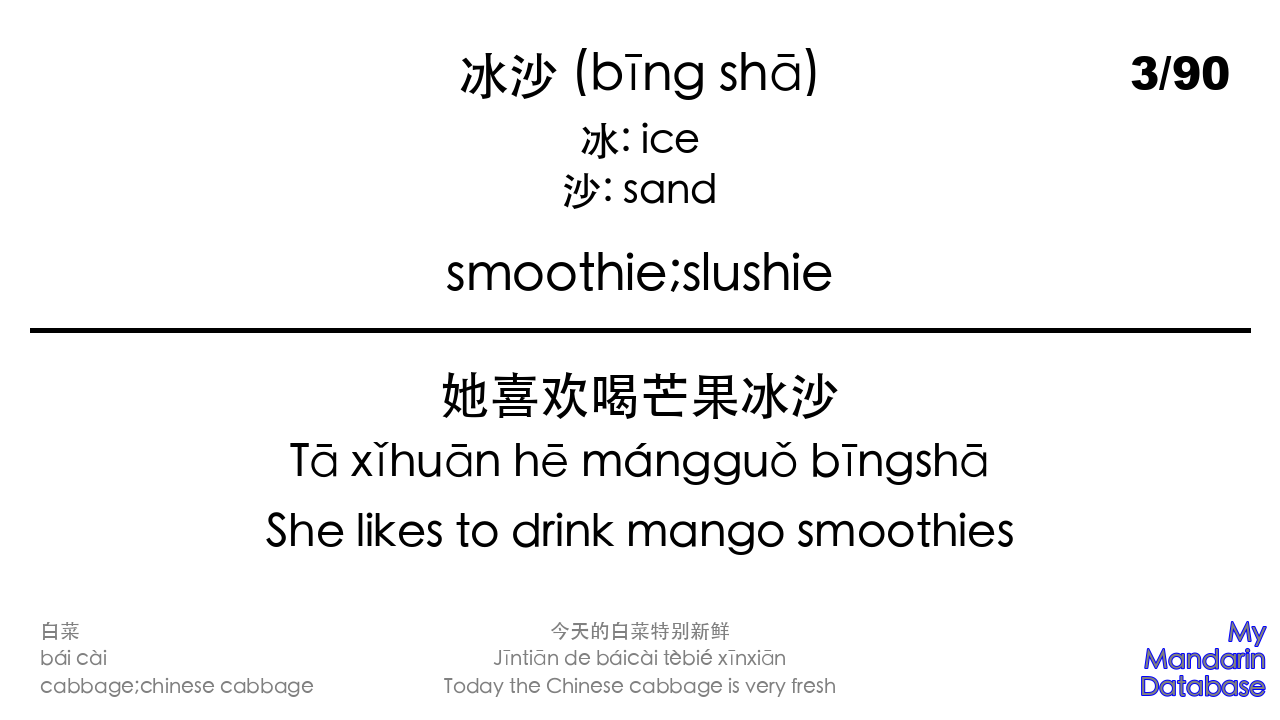

In [165]:
def create_component_words_text(row):
    component_words_text = f"{row['word1']}: {row['word1_english']}\n{row['word2']}: {row['word2_english']}"
    if not pd.isna(row['word3']):
        component_words_text += f"\n{row['word3']}: {row['word3_english']}"
    if not pd.isna(row['word4']):
        component_words_text += f"\n{row['word4']}: {row['word4_english']}"
    return component_words_text

def get_wrapped_text(text: str, font: ImageFont.ImageFont, line_length: int):
    new_lines = ['']
    for original_line in text.split('\n'):
        # Make sure no words are longer than line_length in original line
        # if so, divide it into multiple words to make a new line
        words_split = original_line.split(' ')
        no_long_words_line = ''
        for word in words_split:
            if font.getlength(word) > line_length:
                print(font.getlength(word), word)
                # Split the word into characters
                long_word_chars = list(word)
                new_long_word = ''
                tmp_long_word = ''
                for char in long_word_chars:
                    test_word = f'{tmp_long_word}{char}'
                    if font.getlength(test_word) <= line_length:
                        tmp_long_word = f'{tmp_long_word}{char}'
                    else:
                        new_long_word += f'{tmp_long_word} '
                        tmp_long_word = ''
                no_long_words_line += f'{new_long_word}{tmp_long_word}'
            else:
                no_long_words_line += f'{word} '

        words_split = no_long_words_line.split(' ')
        for word_idx, word in enumerate(words_split):
            test_line = f'{new_lines[-1]} {word}'.strip()
            if word_idx == 0 and new_lines[-1] != '':
                new_lines.append(word)
            elif font.getlength(test_line) <= line_length:
                new_lines[-1] = test_line
            else:
                new_lines.append(word)
    return '\n'.join(new_lines)

def determine_if_text_size_too_big(text: str, font: ImageFont.ImageFont, line_length: int):
    new_lines = ['']
    for original_line in text.split('\n'):
        words_split = original_line.split(' ')
        for word_idx, word in enumerate(words_split):
            test_line = f'{new_lines[-1]} {word}'.strip()
            if word_idx == 0 and new_lines[-1] != '':
                new_lines.append(word)
            elif font.getlength(test_line) <= line_length:
                new_lines[-1] = test_line
            else:
                return True
    return False


def create_text_clip(
        text, duration, timestamp_start, image_file_name
        , size=(1280, 720)
        , bg_color='white'
        , text_color='black'
        ):
    # Use textcip
    # clip_c = TextClip(text=f"{chinese}\n{pinyin}", font='Marker Felt', font_size=70, color=text_color, bg_color=bg_color, size=size, method='label', duration=duration_text_c)
    font = ImageFont.truetype(hanzi_font_path, 50)
    wrapped_text = get_wrapped_text(text, font, line_length=size[0]-60)

    img = Image.new("RGB", size, color=bg_color)
    draw = ImageDraw.Draw(img)
    draw.multiline_text(
        xy=(30, 50), text=wrapped_text, font=font
        , fill=text_color, spacing=30, align='center'
        )

    img_file_path = f"audio_files/img_for_video/{image_file_name}.png"
    img.save(img_file_path)
    return ImageClip(img_file_path, duration=duration).with_start(timestamp_start)


def add_text_and_save_clip(text_settings, img, draw, clips, save_clip=True):
    new_font_size = text_settings['font_size']
    font = ImageFont.truetype(text_settings['font_path'], new_font_size)
    font_size_too_big = determine_if_text_size_too_big(text_settings['text'], font, line_length=BG_SIZE[0]-MAX_LINE_LENGTH_CONSTANT)
    while font_size_too_big:
        new_font_size -= 5
        print(f'reduced font size to {new_font_size}')
        font = ImageFont.truetype(text_settings['font_path'], new_font_size)
        font_size_too_big = determine_if_text_size_too_big(text_settings['text'], font, line_length=BG_SIZE[0]-MAX_LINE_LENGTH_CONSTANT)

    longest_length = max([font.getlength(x) for x in text_settings['text'].split('\n')])
    draw.multiline_text(
        xy=(BG_SIZE[0]/2 - longest_length/2, text_settings['y_pos'])
        , text=text_settings['text'], font=font
        , fill=text_settings['fill'], spacing=text_settings['spacing'], align=text_settings['align']
        )
    if save_clip:
        img_file_path = f"{CURRENT_IMAGE_FILE_PATH_START}_{text_settings['img_file_suffix']}.png"
        img.save(img_file_path)
        my_img = ImageClip(img_file_path, duration=text_settings['duration']).with_start(text_settings['timestamp_start'])
        clips[rrow['recording_name']].append(my_img)
    return img, draw, clips

# Create all clips
TEXT_COLOR = 'black'
BG_COLOR = 'white'
BG_SIZE = (1280, 720)
TEXT_SPACING = 30
TEXT_SPACING_COMPONENTS = 15
MAX_LINE_LENGTH_CONSTANT = 60
FONT_SIZES_BY_TYPE = {
    'words': 50,
    'components': 40,
    'sent_chinese': 50,
    'sent': 45
}
hanzi_font_path = '/System/Library/Fonts/STHeiti Medium.ttc'
clips = {}
# TODO: determine size; decrease if necessary (sentence; decrease if multiple combo words)
# TODO: get position of vocabulary words in sentence
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    n_rows = len(df_audio_durations[rrow['recording_name']])
    previous_word = ''
    previous_sent = ''

    if not os.path.exists(f"audio_files/img_for_video/{rrow['recording_id']}"):
        os.mkdir(f"audio_files/img_for_video/{rrow['recording_id']}")
    clips[rrow['recording_name']] = []
    for idx, row in df_audio_durations[rrow['recording_name']].iterrows():
        if rrow['recording_id'] == '013':
            if for_yt:
                sentence_txt = f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}"
                duration = row['end'] - row['start_sent_english']
                timestamp_start = row['start_sent_english']
                image_file_name = f"{rrow['recording_id']}/{row['chinese']}_sentence_e"

                # Establish texts
                if not pd.isna(row['word4']):
                    font_size_components = FONT_SIZES_BY_TYPE['components'] * .5
                elif not pd.isna(row['word3']):
                    font_size_components = FONT_SIZES_BY_TYPE['components'] * .75
                else:
                    font_size_components = FONT_SIZES_BY_TYPE['components']
                texts = {
                    'chinese': {
                        'text': f"{row['chinese']} ({row['pinyin']})",
                        'y_pos': 50,
                        'font_path': hanzi_font_path,
                        'font_size': FONT_SIZES_BY_TYPE['words'],
                        'fill': TEXT_COLOR,
                        'spacing': TEXT_SPACING,
                        'align': 'center',
                        'duration': row['start_component_words'] - row['start_chinese'],
                        'timestamp_start': row['start_chinese'],
                        'img_file_suffix': '_chinese',
                        },
                    'component_words': {
                        'text': create_component_words_text(row),
                        'y_pos': 120,
                        'font_path': hanzi_font_path,
                        'font_size': font_size_components,
                        'fill': TEXT_COLOR,
                        'spacing': TEXT_SPACING_COMPONENTS,
                        'align': 'center',
                        'duration': row['start_english'] - row['start_component_words'],
                        'timestamp_start': row['start_component_words'],
                        'img_file_suffix': '_component_words',
                        },
                    'english': {
                        'text': row['english'],
                        'y_pos': 250,
                        'font_path': hanzi_font_path,
                        'font_size': FONT_SIZES_BY_TYPE['words'],
                        'fill': TEXT_COLOR,
                        'spacing': TEXT_SPACING,
                        'align': 'center',
                        'duration': row['start_sent'] - row['start_english'],
                        'timestamp_start': row['start_english'],
                        'img_file_suffix': '_component_words_english',
                        },
                    'sentence_chinese': {
                        'text': row['sentence'],
                        'y_pos': 370,
                        'font_path': hanzi_font_path,
                        'font_size': FONT_SIZES_BY_TYPE['sent_chinese'],
                        'fill': TEXT_COLOR,
                        'spacing': TEXT_SPACING,
                        'align': 'center',
                        'duration': None,
                        'timestamp_start': None,
                        'img_file_suffix': None,
                        },
                    'sentence_pinyin': {
                        'text': row['sentence_pinyin'],
                        'y_pos': 440,
                        'font_path': hanzi_font_path,
                        'font_size': FONT_SIZES_BY_TYPE['sent'],
                        'fill': TEXT_COLOR,
                        'spacing': TEXT_SPACING,
                        'align': 'center',
                        'duration': row['start_sent_english'] - row['start_sent'],
                        'timestamp_start': row['start_sent'],
                        'img_file_suffix': '_sentence',
                        },
                    'sentence_english': {
                        'text': row['sentence_english'],
                        'y_pos': 510,
                        'font_path': hanzi_font_path,
                        'font_size': FONT_SIZES_BY_TYPE['sent'],
                        'fill': TEXT_COLOR,
                        'spacing': TEXT_SPACING,
                        'align': 'center',
                        'duration': row['end'] - row['start_sent_english'],
                        'timestamp_start': row['start_sent_english'],
                        'img_file_suffix': '_sentence_e',
                        },
                }

                # Initialize image
                img = Image.new("RGB", BG_SIZE, color=BG_COLOR)
                draw = ImageDraw.Draw(img)

                # Constant texts
                draw.text(text=f"{idx+1}/{n_rows}", xy=(BG_SIZE[0] - 150, 40)
                          , font=ImageFont.truetype('Arial Black', 44), fill = 'black', align='center')
                draw.multiline_text(
                    xy=(40, BG_SIZE[1] - 100)
                    , text=previous_word
                    , font=ImageFont.truetype(hanzi_font_path, 20)
                    , fill='gray', spacing=10, align='left'
                    )
                sent_font = ImageFont.truetype(hanzi_font_path, 20)
                longest_length = max([sent_font.getlength(x) for x in previous_sent.split('\n')])
                draw.multiline_text(
                    xy=(BG_SIZE[0]/2 - longest_length/2, BG_SIZE[1] - 100)
                    , text=previous_sent
                    , font=sent_font
                    , fill='gray', spacing=10, align='center'
                    )
                draw.multiline_text(
                    xy=(BG_SIZE[0] - 140, BG_SIZE[1] - 100)
                    , text='My\nMandarin\nDatabase'
                    , font=ImageFont.truetype(hanzi_font_path, 26)
                    , fill='gray', spacing=2, align='right'
                    , stroke_width=1, stroke_fill='blue'
                    )
                previous_word = f"{row['chinese']}\n{row['pinyin']}\n{row['english']}"
                previous_sent = f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}"

                # Add each text and create a new clip as appropriate
                CURRENT_IMAGE_FILE_PATH_START = f"audio_files/img_for_video/{rrow['recording_id']}/{row['chinese']}_"
                img, draw, clips = add_text_and_save_clip(texts['chinese'], img, draw, clips)
                img, draw, clips = add_text_and_save_clip(texts['component_words'], img, draw, clips)
                img, draw, clips = add_text_and_save_clip(texts['english'], img, draw, clips)
                draw.line([(30, 330), (BG_SIZE[0] - 30, 330)], fill='black', width=5, joint=None)
                img, draw, clips = add_text_and_save_clip(texts['sentence_chinese'], img, draw, clips, save_clip=False)
                img, draw, clips = add_text_and_save_clip(texts['sentence_pinyin'], img, draw, clips)
                img, draw, clips = add_text_and_save_clip(texts['sentence_english'], img, draw, clips)

            else:
                raise ValueError('do the youtube verison')
        
        elif rrow['recording_id'] == '006':
            clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}", row['start_component_words'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_chinese"))
            component_words_text = create_component_words_text(row)
            clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}\n{component_words_text}", row['start_english'] - row['start_component_words'], row['start_component_words'], f"{rrow['recording_id']}/{row['chinese']}_component_words"))
            clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}\n{component_words_text}\n{row['english']}", row['end'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_component_words_english"))
        
        elif rrow['recording_id'] == '001':
            clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']} ({row['pinyin']})", row['start_english'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_chinese"))
            clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']} ({row['pinyin']}): {row['english']}", row['start_sent'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_english"))
            clips[rrow['recording_name']].append(create_text_clip(f"{row['sentence']}\n{row['sentence_pinyin']}", row['start_sent_english'] - row['start_sent'], row['start_sent'], f"{rrow['recording_id']}/{row['chinese']}_sentence"))
            clips[rrow['recording_name']].append(create_text_clip(f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}", row['end'] - row['start_sent_english'], row['start_sent_english'], f"{rrow['recording_id']}/{row['chinese']}_sentence_e"))
        
        elif rrow['recording_id'] == '012':
            clips[rrow['recording_name']].append(create_text_clip(f"{row['english']}", row['start_chinese'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_english"))
            clips[rrow['recording_name']].append(create_text_clip(f"{row['english']}\n{row['chinese']} ({row['pinyin']})", row['start_sent'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_chinese"))
            clips[rrow['recording_name']].append(create_text_clip(f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}", row['end'] - row['start_sent'], row['start_sent'], f"{rrow['recording_id']}/{row['chinese']}_sentence"))
        
        elif rrow['recording_id'] in ['004', '008', '010', '014']:
            clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}", row['start_english'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_chinese"))
            clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']} ({row['pinyin']})\n{row['english']}", row['end'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_english"))
        
        elif rrow['recording_id'] in ['016']:
            clips[rrow['recording_name']].append(create_text_clip(f"{row['english']}", row['start_chinese'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_english"))
            clips[rrow['recording_name']].append(create_text_clip(f"{row['english']}\n{row['chinese']} ({row['pinyin']})", row['end'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_full"))
        
        elif rrow['recording_id'] in ['015']:
            clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']} ({row['pinyin']}): {row['english']}\n --------- \n{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}", row['end'] - row['start'], row['start'], f"{rrow['recording_id']}/{row['chinese']}"))
        
        else:
            raise ValueError(f"Unknown vlaue of recording_id: {rrow['recording_id']}")
        
        print(f'{rrow['recording_name']}; {idx}: {row["chinese"]}')
        # if idx % 3 == 2:
        #     break

clips[rrow['recording_name']][14].display_in_notebook()


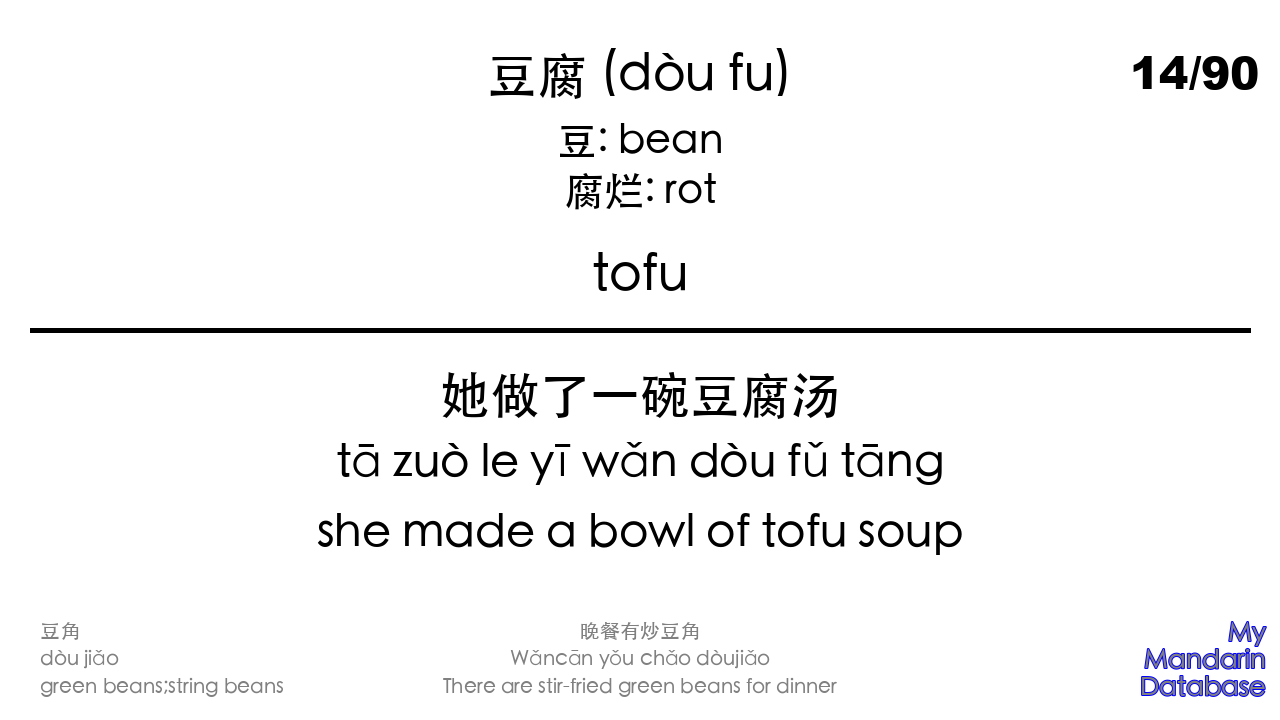

In [166]:
clips[rrow['recording_name']][69].display_in_notebook()


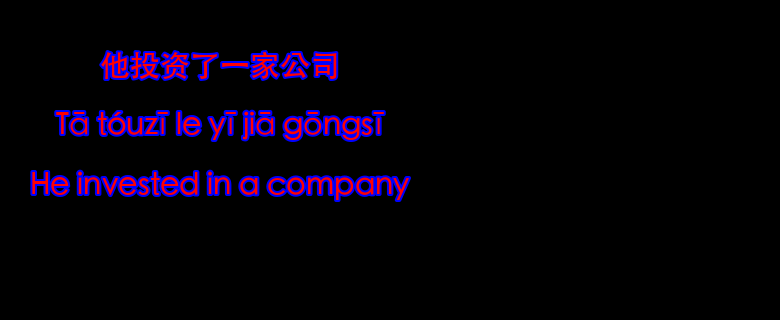

In [ ]:
# img = Image.new("RGB", (780, 320))
# draw = ImageDraw.Draw(img)
# draw.multiline_text(xy=(30, 50), text=f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}"
#                     , font=ImageFont.truetype(hanzi_font_path, 30)
#                     , spacing=30
#                     , align='center'
#                     , fill='red'
#                     , direction='ltr'
#                     , stroke_width=2
#                     , stroke_fill='blue'
#                     )
# img.save("tmp.png")
# ImageClip("tmp.png", duration=1).with_start(0).display_in_notebook()

In [ ]:
# Create intro slide

# My Mandarin Database video #001
# Settings:
    # Category: food
    # Type: Components and sentences
    # Produced date: X
    # Number of words: X
    # Duration: X
    # Structure: Chinese first, then english
    # If you have any questions, suggestions, or feedback, please leave a comment
# Audio: "My Mandarin database audio recording #001. Name. Number of words, minutes."

In [ ]:
# Create final slide

# My Mandarin Database video #001
# Settings:
    # Category: food
    # Type: Components and sentences
    # Produced date: X
    # Number of words: X
    # Duration: X
    # Structure: Chinese first, then english
    # If you have any questions, suggestions, or feedback, please leave a comment
# Audio: "My Mandarin database audio recording #001 is over. Name."
# 我的普通话数据库
# Please like and subscribe (in Chinese)

"cabbage;chinese cabbage" reduced font size to 16
"cabbage;chinese cabbage" reduced font size to 14
"cabbage;chinese cabbage" reduced font size to 12
"expiration date;shelf life" reduced font size to 16
"green beans;string beans" reduced font size to 16
"green beans;string beans" reduced font size to 14
"cabbage;round cabbage" reduced font size to 16
"cabbage;round cabbage" reduced font size to 14
"墨西哥卷饼" reduced font size to 16
"墨西哥卷饼" reduced font size to 14
"墨西哥卷饼" reduced font size to 12
"mò xī gē juǎn bǐng" reduced font size to 16
"mò xī gē juǎn bǐng" reduced font size to 14
"食物中毒" reduced font size to 16
"食物中毒" reduced font size to 14
"by hand;manual;handmade" reduced font size to 16
"by hand;manual;handmade" reduced font size to 14
"by hand;manual;handmade" reduced font size to 12
"羊角面包" reduced font size to 16
"羊角面包" reduced font size to 14
"yáng jiǎo miàn bāo" reduced font size to 16
"yáng jiǎo miàn bāo" reduced font size to 14
"意式浓缩" reduced font size to 16
"意式浓缩" reduced fon


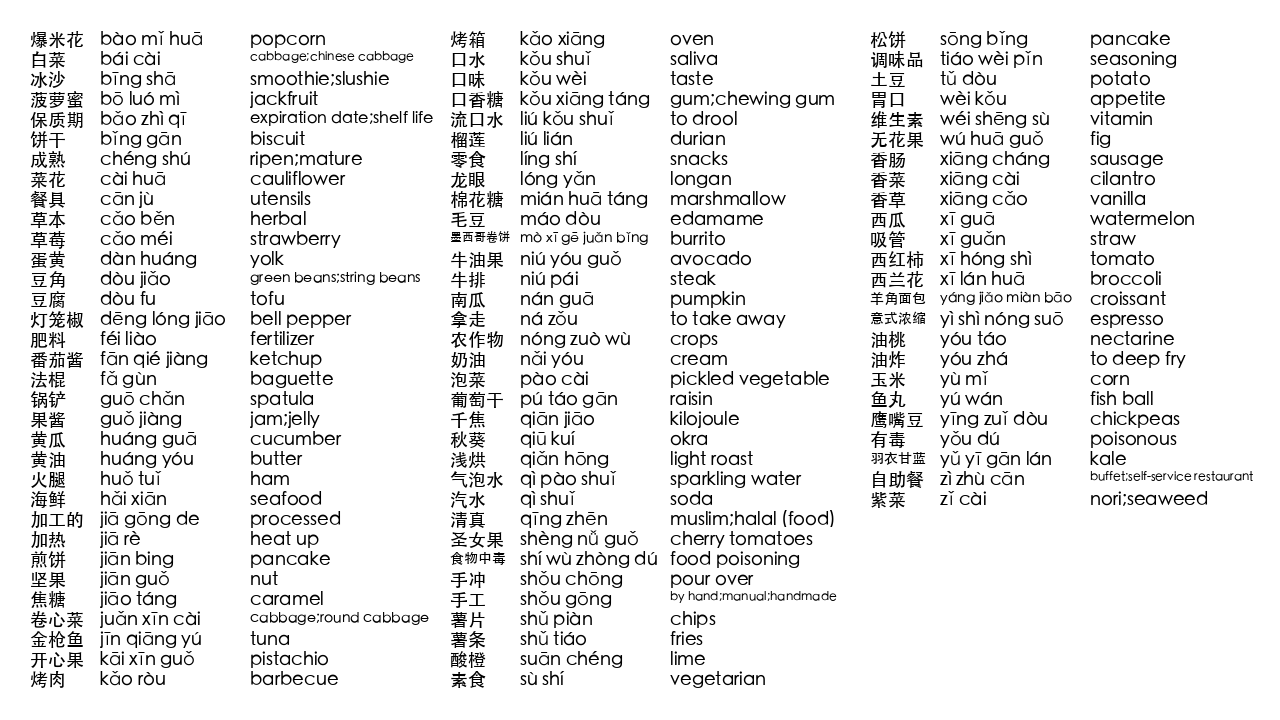

In [ ]:
# Create slide with all words
# Audio: "here are the X words over the next X minutes"
ALL_WORDS_SLIDE_YTOP = 30
ALL_WORDS_SLIDE_XTOP = 30
ALL_WORDS_SLIDE_FONT_SIZE = 18
ALL_WORDS_SLIDE_TEXT_FILL = 'black'
ALL_WORDS_SLIDE_TEXT_ALIGN = 'left'
ALL_WORDS_SLIDE_TEXT_COL_SPACE = 10
ALL_WORDS_SLIDE_TEXT_COL_SPACE_BIG = 10
ALL_WORDS_DEF_PARTS = {
    'chinese': {'x_offset': 0, 'x_max': 60, 'font_path': hanzi_font_path},
    'pinyin': {'x_offset': None, 'x_max': 140, 'font_path': hanzi_font_path},
    'english': {'x_offset': None, 'x_max': 190, 'font_path': hanzi_font_path},
}

# Derived
ALL_WORDS_SLIDE_YCHANGE = ALL_WORDS_SLIDE_FONT_SIZE + 2
ALL_WORDS_DEF_PARTS['pinyin']['x_offset'] = ALL_WORDS_DEF_PARTS['chinese']['x_offset'] + ALL_WORDS_DEF_PARTS['chinese']['x_max'] + ALL_WORDS_SLIDE_TEXT_COL_SPACE
ALL_WORDS_DEF_PARTS['english']['x_offset'] = ALL_WORDS_DEF_PARTS['pinyin']['x_offset'] + ALL_WORDS_DEF_PARTS['pinyin']['x_max'] + ALL_WORDS_SLIDE_TEXT_COL_SPACE
ALL_WORDS_SLIDE_XCHANGE = ALL_WORDS_DEF_PARTS['english']['x_offset'] + ALL_WORDS_DEF_PARTS['english']['x_max'] + ALL_WORDS_SLIDE_TEXT_COL_SPACE_BIG

n_offsets = 0
last_y_offset_idx = 0
cur_y_offset = ALL_WORDS_SLIDE_YTOP
cur_x_offset = ALL_WORDS_SLIDE_XTOP

for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    n_rows = len(df_audio_durations[rrow['recording_name']])
    # Initialize image
    img = Image.new("RGB", BG_SIZE, color=BG_COLOR)
    draw = ImageDraw.Draw(img)
    for idx, row in df_audio_durations[rrow['recording_name']].iterrows():
        for def_part, dp_settings in ALL_WORDS_DEF_PARTS.items():
            new_font_size = ALL_WORDS_SLIDE_FONT_SIZE
            font = ImageFont.truetype(dp_settings['font_path'], new_font_size)
            font_size_too_big = determine_if_text_size_too_big(row[def_part], font, line_length=dp_settings['x_max'])
            while font_size_too_big:
                new_font_size -= 2
                print(f'"{row[def_part]}" reduced font size to {new_font_size}')
                font = ImageFont.truetype(dp_settings['font_path'], new_font_size)
                font_size_too_big = determine_if_text_size_too_big(row[def_part], font, line_length=dp_settings['x_max'])
            
            # Compute current X and Y positions
            y_pos_v1 = (cur_y_offset + ALL_WORDS_SLIDE_YCHANGE*(idx - last_y_offset_idx))
            
            if y_pos_v1 > (BG_SIZE[1] - ALL_WORDS_SLIDE_YCHANGE - ALL_WORDS_SLIDE_YTOP):
                n_offsets += 1
                last_y_offset_idx = idx
                cur_y_offset = ALL_WORDS_SLIDE_YTOP
                cur_x_offset += ALL_WORDS_SLIDE_XCHANGE

            x_pos = cur_x_offset + dp_settings['x_offset']
            y_pos_v2 = cur_y_offset + ALL_WORDS_SLIDE_YCHANGE*(idx - last_y_offset_idx)
            
            draw.text(
                xy=(x_pos, y_pos_v2), text=row[def_part], font=font
                , fill=ALL_WORDS_SLIDE_TEXT_FILL, spacing=0, align=ALL_WORDS_SLIDE_TEXT_ALIGN
                )
    
    img_file_path = f"audio_files/img_for_video/{rrow['recording_id']}/ALL_WORDS_{rrow['recording_name']}.png"
    img.save(img_file_path)
    my_img = ImageClip(img_file_path, duration=1).with_start(0)
my_img.display_in_notebook()

## 6b. Create video with audio

In [167]:
# Load audio
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    audio = AudioFileClip(f"audio_files/products/{rrow['recording_name']}.mp3")
    # Compare durations of audio and video
    all_clips_duration = sum(clip.duration for clip in clips[rrow['recording_name']])
    print(f"{rrow['recording_name']}: audio: {audio.duration:.3f}s, video: {all_clips_duration:.3f}s; difference: {audio.duration - all_clips_duration:.3f}s")

0911_013_ccombo_sent_p1_4_food_yt: audio: 1601.110s, video: 1601.058s; difference: 0.052s


In [168]:
# NOTE: Issue with first, 012 liter
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    video_file_name = f"audio_files/products/videos/{rrow['recording_name']}_video.mp4"
    if os.path.exists(video_file_name):
        print(f"Video already exists: {video_file_name}, skipping...")
    else:
        video = CompositeVideoClip(clips[rrow['recording_name']], size=(1280,720))
        audio = AudioFileClip(f"audio_files/products/{rrow['recording_name']}.mp3")
        video.audio = audio
        video.duration = audio.duration
        video.write_videofile(video_file_name, fps=24)

MoviePy - Building video audio_files/products/videos/0911_013_ccombo_sent_p1_4_food_yt_video.mp4.
MoviePy - Writing audio in 0911_013_ccombo_sent_p1_4_food_yt_videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video audio_files/products/videos/0911_013_ccombo_sent_p1_4_food_yt_video.mp4



MoviePy - Done !
MoviePy - video ready audio_files/products/videos/0911_013_ccombo_sent_p1_4_food_yt_video.mp4


In [ ]:
# 